## Objective

Build a model that predicts the total ride duration of the taxi trips in New York City

Data Released by: NYC Taxi and Limousine Commission and Kaggle

File Descriptions:
- Training Data (1,458,644 trip records)
- Test Data (625,134 trip records)

Data Fields:

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds


References:
- https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation/notebook



In [19]:
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
#from matplotlib import animation
#from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser

#import base64

#from IPython.display import HTML
#from imblearn.under_sampling import RandomUnderSampler
#from subprocess import check_output



In [3]:
# Import the data
df = pd.read_csv("../train.csv")

In [4]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df.shape

(1458644, 11)

In [6]:
# Remove rides "to" and "from" outside the NYC

xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

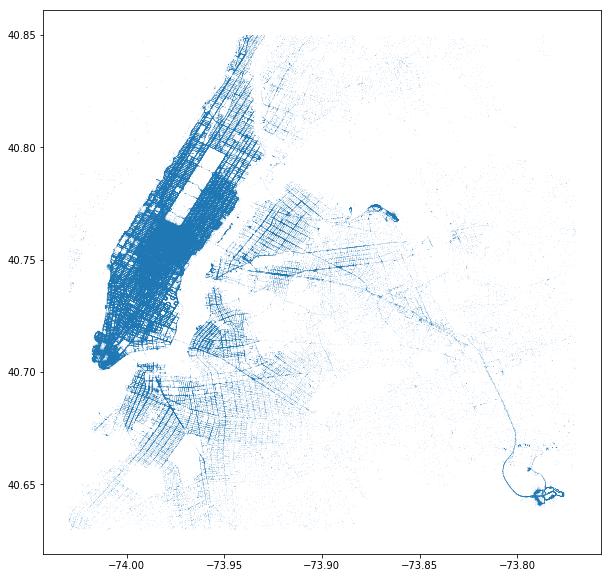

In [7]:
# Plotting the different rides in NYC

longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)

plt.figure(figsize = (10,10))
plt.plot(longitude, latitude,'+', alpha =0.8, markersize =0.05)
plt.show()

In [8]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

loc_df.head()

,longitude,latitude
0,-73.982155,40.767937
1,-73.980415,40.738564
2,-73.979027,40.763939
3,-74.010040,40.719971
4,-73.973053,40.793209


## Cluster

Cluster the samples based on rides pick-up and drop-off points

In [10]:
kmeans = KMeans(n_clusters=15, random_state=4, n_init = 10, n_jobs=-1).fit(loc_df)
loc_df['label']= kmeans.labels_

loc_df.head()

,longitude,latitude,label
0,-73.982155,40.767937,13
1,-73.980415,40.738564,3
2,-73.979027,40.763939,13
3,-74.010040,40.719971,11
4,-73.973053,40.793209,6


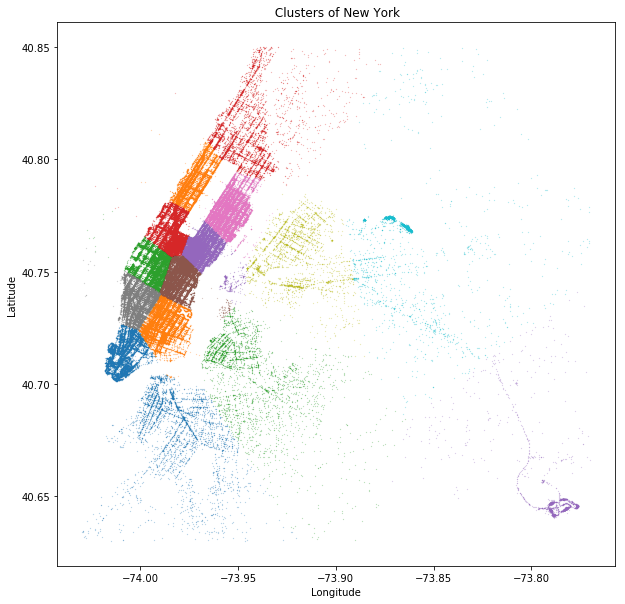

In [11]:
loc_df = loc_df.sample(200000)
plt.figure(figsize=(10,10))

for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label==label], 
             loc_df.latitude[loc_df.label ==label], '.', 
             alpha=0.8, markersize =0.3 )
    
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(" Clusters of New York")

plt.show()

Plot the cluster centers

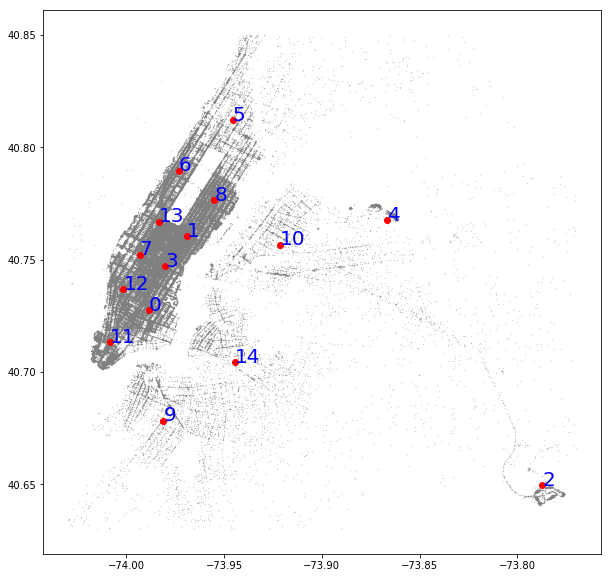

In [17]:
plt.figure(figsize = (10,10))

# need to check difference b/w fig, ax here

for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label==label], 
             loc_df.latitude[loc_df.label ==label], '.', 
             alpha=0.8, markersize =0.3, color= 'gray' )
    
    plt.plot(kmeans.cluster_centers_[label,0], kmeans.cluster_centers_[label,1],
           'o', color='r')
    
    plt.annotate(label, (kmeans.cluster_centers_[label,0], 
                        kmeans.cluster_centers_[label,1]),
                color ='b', fontsize = 20)
ax.set_title("Cluster Centers")
plt.show()

In [20]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])

df['pickup_hour']= df.pickup_datetime.apply(lambda x : parser.parse(x).hour)

In [21]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,13,1,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,3,12,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,13,11,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,11,11,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6,6,13


In [22]:
# Coordinates of cluster centers

clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))